In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import copy
import os
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.activations import linear, sigmoid, relu, softmax
from utility_lib_MNIST import *


<a name="1.1"></a>
### 1.1 Problem Statement

In this exercise, you will use a neural network to recognize ten handwritten digits, 0-9. This is a multiclass classification task where one of n choices is selected. Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. 

<a name="1.2"></a>
### 1.2 Dataset

You will start by loading the dataset for this task. 

- The data set contains 5000 training examples of handwritten digits $^1$.  

    - Each training example is a 20-pixel x 20-pixel grayscale image of the digit. 
        - Each pixel is represented by a floating-point number indicating the grayscale intensity at that location. 
        - The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. 
        - Each training examples becomes a single row in our data matrix `X`. 
        - This gives us a 5000 x 400 matrix `X` where every row is a training example of a handwritten digit image.

$$X = 
\left(\begin{array}{cc} 
--- (x^{(1)}) --- \\
--- (x^{(2)}) --- \\
\vdots \\ 
--- (x^{(m)}) --- 
\end{array}\right)$$ 

- The second part of the training set is a 5000 x 1 dimensional vector `y` that contains labels for the training set
    - `y = 0` if the image is of the digit `0`, `y = 4` if the image is of the digit `4` and so on.

$^1$<sub> This is a subset of the MNIST handwritten digit dataset (http://yann.lecun.com/exdb/mnist/)</sub>

In [ ]:
os.makedirs('./Dataset')

In [3]:
os.listdir('./Dataset')

['X.npy', 'y.npy']

In [3]:
path = './Data_C2_W2_MNIST_Digit_Classification'
x_train = np.load(f'{path}/X.npy')
y_train = np.load(f'{path}/y.npy')

In [4]:
print(f'Shape of x_train dataset: {x_train.shape}')
print(f'Shape of y_train dataset: {y_train.shape}')

Shape of x_train dataset: (5000, 400)
Shape of y_train dataset: (5000, 1)


<a name="1.3"></a>
### 1.3 Variables

In [5]:
print(f'The first element of X is : {x_train[0]}')

The first element of X is : [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+

In [6]:
print(f'The first line of y is : {y_train[0,0]}')
print(f'The last line of y is : {y_train[-1,0]}')

The first line of y is : 0
The last line of y is : 9


<a name='1.4'></a>
### 1.4 Visualizing the Data

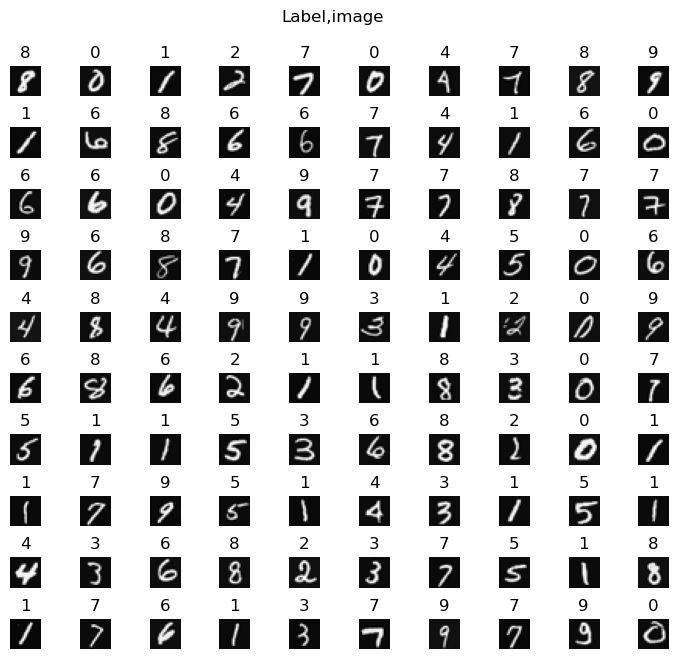

In [7]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=FutureWarning)

m, n = x_train.shape

fig, axes = plt.subplots(10, 10, figsize=(7, 7))
fig.tight_layout(pad=0.13, rect=[0, 0.03, 1, 0.91])

# Remove widgvis(fig) unless it's necessary
for i, ax in enumerate(axes.flat):
    index = np.random.randint(m)  # Select random image
    x_train_reshaped = x_train[index].reshape((20, 20)).T  # Ensure correct shape
    
    ax.imshow(x_train_reshaped, cmap="gray")
    
    # Ensure y_train indexing is correct
    ax.set_title(f'{y_train[index]}' if y_train.ndim == 1 else f'{y_train[index, 0]}')
    
    ax.set_axis_off()

fig.suptitle("Label,image")
plt.show()  # Ensure the plot is displayed


<a name="1.5"></a>
### 1.5 Model representation

The neural network you will use in this assignment is shown in the figure below. 
- This has two dense layers with ReLU activations followed by an output layer with a linear activation. 
    - Recall that our inputs are pixel values of digit images.
    - Since the images are of size $20\times20$, this gives us $400$ inputs  
    


In [8]:
tf.random.set_seed(1234)
model = Sequential(
    [
        tf.keras.Input(shape=(400,)),
        Dense(units=25,activation='relu',name='L1'),
        Dense(units=15,activation='relu',name='L2'),
        Dense(units=10,activation='linear',name='L3'),
    ],name='my_model'
)
model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ L1 (Dense)                      │ (None, 25)             │        10,025 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2 (Dense)                      │ (None, 15)             │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L3 (Dense)                      │ (None, 10)             │           160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,575 (41.31 KB)

 Trainable params: 10,575 (41.31 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
)
history = model.fit(
    x_train,y_train,epochs=40
)

Epoch 1/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.9661
Epoch 2/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7277
Epoch 3/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4321
Epoch 4/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3303
Epoch 5/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2780
Epoch 6/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2442
Epoch 7/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2199
Epoch 8/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2004
Epoch 9/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1841
Epoch 10/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1703
Epoch 11/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1585
Epoch 12/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1483
Epoch 13/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1395
Epoch 14/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1313
Epoch 15/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

In [10]:
[layer1,layer2,layer3] = model.layers
W1,b1 = model.get_layer('L1').get_weights()
W2,b2 = model.get_layer('L2').get_weights()
W3,b3 = model.get_layer('L3').get_weights()


print(f'Size of W1: {W1.shape}, b1: {b1.shape}')
print(f'Size of W2: {W2.shape}, b2: {b2.shape}')
print(f'Size of W3: {W3.shape}, b3: {b3.shape}')

Size of W1: (400, 25), b1: (25,)
Size of W2: (25, 15), b2: (15,)
Size of W3: (15, 10), b3: (10,)


<a name = '1.6'></a>
### 1.6 Plot Learning Curve

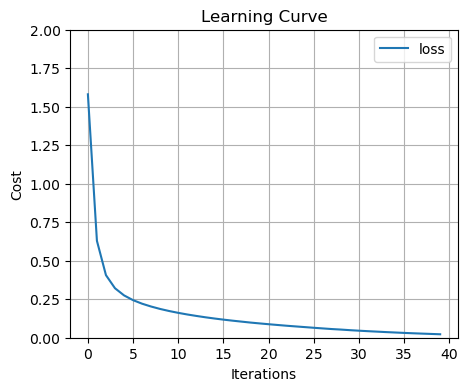

In [11]:
plt_learning_curve(history)

<a name = "1.7"></a>
### 1.7 Prediction

In [12]:
prediction = model.predict(x_train)
print(prediction.shape)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(5000, 10)


In [13]:

predict_probability = tf.nn.softmax(prediction)

# Initialize y_predicted
m = predict_probability.shape[0]
y_predicted = np.zeros(m)

# Get predicted class
for i in range(len(predict_probability)):
    y_predicted[i] = np.argmax(predict_probability[i])

# Print current shape (should be (5000,))
print("Before expanding:", y_predicted.shape)  

# Expand dimensions correctly
y_predicted = np.expand_dims(y_predicted, axis=1)  # Shape: (5000,1)

# Print new shape
print("After expanding:", y_predicted.shape)


Before expanding: (5000,)
After expanding: (5000, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


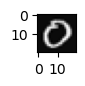

True_value: [0], 
predicted_output: [[21.433184   -3.984826    2.8679452  -0.9430513  -7.364611    4.354796
  -0.18686953 -7.6831455   4.857809    0.13548389]], 
predicted_probability: [[9.9999988e-01 9.1431992e-12 8.6540446e-09 1.9148068e-10 3.1137007e-13
  3.8278088e-08 4.0787820e-10 2.2643256e-13 6.3300369e-08 5.6302391e-10]],
Prediction : 0


In [14]:
idx = np.random.randint(m)
predict = model.predict(x_train[idx].reshape(1,400))
prob_predict = softmax(predict)
display_digit(x_train[idx])
print(f'True_value: {y_train[idx]}, \npredicted_output: {predict}, \npredicted_probability: {prob_predict},\nPrediction : {np.argmax(prob_predict)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

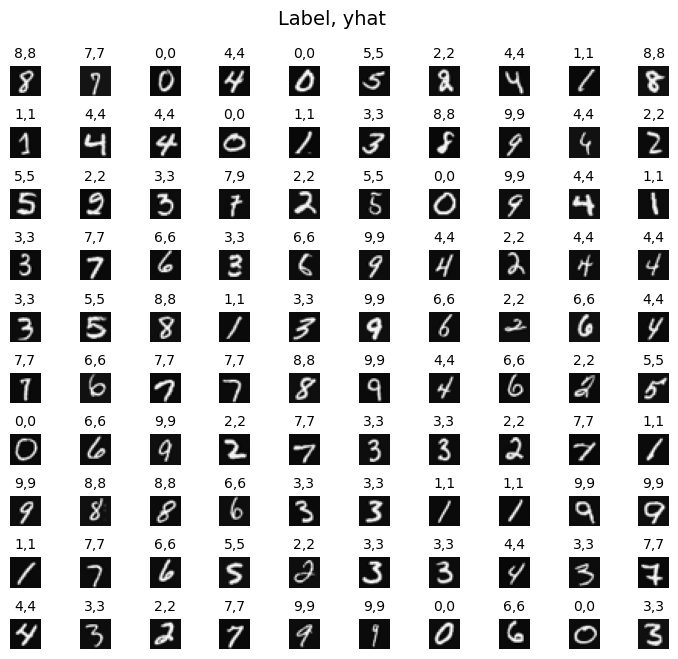

In [15]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = x_train.shape

fig, axes = plt.subplots(10,10, figsize=(7,7))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]
# widgvis(fig)
for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    x_train_random_reshaped = x_train[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(x_train_random_reshaped, cmap='gray')
    
    # Predict using the Neural Network
    prediction = model.predict(x_train[random_index].reshape(1,400))
    prediction_p = tf.nn.softmax(prediction)
    yhat = np.argmax(prediction_p)
    
    # Display the label above the image
    ax.set_title(f"{y_train[random_index,0]},{yhat}",fontsize=10)
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=14)
plt.show()

In [17]:
def count_error(model, X, y):
    f = model.predict(X)
    yhat = np.argmax(f, axis=1)
    idxs = np.where(yhat != y[:, 0])[0]

    if len(idxs) == 0:
        print("No errors found")
    else:
        cnt = len(idxs)
        x = math.ceil(math.sqrt(cnt))
        
        # Create subplots
        fig, ax = plt.subplots(x, x, figsize=(5, 5))
        fig.tight_layout(pad=0.13, rect=[0, 0.03, 1, 0.80])
        
        # Convert ax into a 2D array if needed
        ax = np.array(ax).reshape(x, x)
        
        for i in range(cnt):
            j = idxs[i]
            row, col = divmod(i, x)  # Convert i into 2D index

            X_reshaped = X[j].reshape((20, 20)).T
            ax[row, col].imshow(X_reshaped, cmap="gray")

            # Predict again for label
            X_sample = X[j].reshape(1, -1)  # Ensure correct shape
            prediction = model.predict(X_sample)
            prediction_p = tf.nn.softmax(prediction)
            yhat = np.argmax(prediction_p)

            # Display label
            ax[row, col].set_title(f"{y[j,0]},{yhat}", fontsize=10)
            ax[row, col].set_axis_off()

        fig.suptitle("Label, yhat", fontsize=12)
        plt.show()  # Show the figure
    
    return len(idxs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


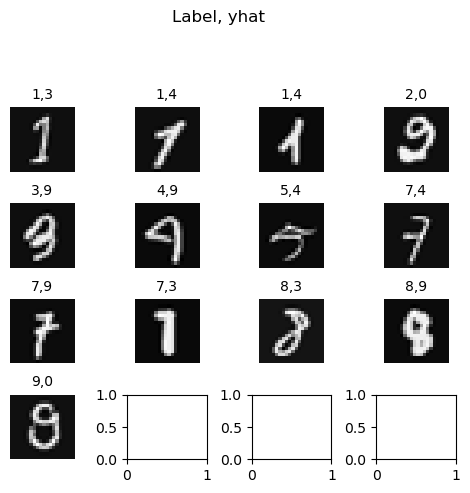

13 errors out of 5000 training samples


In [18]:
cnt_error = count_error(model,x_train,y_train)
print(f'{cnt_error} errors out of {m} training samples')


<a name = "1.8"></a>
### 1.8 Accuracy Calculation

In [20]:
def calculate_accuracy(y_train,y_predicted):
    accuracy = np.mean(y_train == y_predicted) * 100
    return accuracy
accuracy = calculate_accuracy(y_train,y_predicted)
print(f'Accuracy: {accuracy:0.2f}%')

Accuracy: 99.74%
